In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
import skimage
import os
import sys
import sqlite3
import shutil
from time import time
sys.path.append(os.environ['REPO_DIR'])
from lib.utils import configuration, run
from matplotlib.path import Path
from shapely.geometry import Polygon

In [2]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y


def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))

def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [150]:
stack = 'MD594'
section = 98
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}


fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')
valid_sections = np.sort(contours['section'].unique())

fn = 'CSHL_data_processed/MD589/ThresholdsV2.pkl'
setup_download_from_s3(fn, recursive=False)
thresholds = pickle.load(open(os.environ['ROOT_DIR']+fn,'rb'))

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


In [4]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1
num_round = 100

cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD589/'
cell2_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD585/'

savepath = 'CSHL_cells_mark/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)
savepath = savepath+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)

resol = 0.46

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

margin = 200/0.46

In [151]:
polygons = [(contour['name'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group(section).iterrows()]

db_dir = 'CSHL_databases/' + stack + '/'
db_fp = db_dir + str(section) + '.db'
setup_download_from_s3(db_fp, recursive=False)
conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
cur = conn.cursor()

run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/98.db /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/98.db


In [152]:
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape

run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_prep2_lossless_gray.tif /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_prep2_lossless_gray.tif


In [154]:
%%time
# hsv = np.zeros([m, n, 3])
# hsv[:, :, 2] = img / 255
count = 0
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()

#     if structure == '7n':
#         structure = '7nn'

#     fp = []
#     fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
#     fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
#     X_train = []
#     y_train = []
#     for state in range(2):
#         clouds = pickle.load(open(fp[state], 'rb'))
#         X_train.extend(np.array(clouds))
#         y_train.extend([1 - state] * len(clouds))

#     fp = []
#     fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
#     fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
#     for state in range(2):
#         clouds = pickle.load(open(fp[state], 'rb'))
#         X_train.extend(np.array(clouds))
#         y_train.extend([1 - state] * len(clouds))
#     X_train = np.array(X_train)
#     y_train = np.array(y_train)
#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

#     if structure == '7nn':
#         structure = '7n'

    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin),n)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin),m))]
    hsv = np.zeros([down-up, right-left, 3])
    hsv[:, :, 2] = img[up:down,left:right] / 255
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    
#     inside_area = Polygon(polygon).area
#     outside_area = Polygon(polygon).buffer(margin, resolution=2).area - inside_area
    
    path = Path(polygon)
    indices_inside = np.where(path.contains_points(locations))[0]
    features_inside = features[indices_inside]
    locations_inside = locations[indices_inside]
    
    surround = Polygon(polygon).buffer(margin, resolution=2)
    path = Path(list(surround.exterior.coords))
    indices_sur = np.where(path.contains_points(locations))[0]
    indices_outside = np.setdiff1d(indices_sur, indices_inside)
    features_outside = features[indices_outside]
    locations_outside = locations[indices_outside]
    
    for k in range(features_inside.shape[1]):
        x, y = CDF(features_inside[:,k])
        inside = [y[np.argmin(np.absolute(x - thresholds[k][j]))] for j in range(99)]
        x, y = CDF(features_outside[:,k])
        outside = [y[np.argmin(np.absolute(x - thresholds[k][j]))] for j in range(99)]
        diff = np.array(inside) - np.array(outside)
        if (np.absolute(diff)>0.1).sum()>0:
            values = np.array(thresholds[k])
            choose = set(values[np.absolute(diff)>0.1])
            for element in choose:
                posi = np.argmin(np.absolute(features_inside[:,k] - element))
                cx = int(locations_inside[posi, 0])
                cy = int(locations_inside[posi, 1])
                height = int(features_inside[posi, 11]/2)
                width = int(features_inside[posi, 19]/2)
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 0] = 1.0/20*k
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 1] = 1.0
                
                nega = np.argmin(np.absolute(features_outside[:,k] - element))
                cx = int(locations_outside[nega, 0])
                cy = int(locations_outside[nega, 1])
                height = int(features_outside[nega, 11]/2)
                width = int(features_outside[nega, 19]/2)
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 0] = 1.0/20*k
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 1] = 0.9
        else:
            continue

    count += 1
    print(section, structure, count, '/', len(polygons))

98 VCA 1 / 1
CPU times: user 114 ms, sys: 74.3 ms, total: 189 ms
Wall time: 391 ms


In [42]:
bst.get_score(importance_type='cover')

{'f1078': 267.86319256,
 'f859': 279.25,
 'f99': 244.5,
 'f194': 34.75,
 'f1129': 215.270179696,
 'f404': 170.59101099999998,
 'f1354': 152.998825,
 'f1076': 329.439209,
 'f857': 149.81799785,
 'f198': 220.683823,
 'f197': 60.9856987,
 'f1156': 207.0561751425,
 'f1526': 192.794876,
 'f1744': 65.6670837,
 'f1077': 268.2307844,
 'f821': 247.366776,
 'f891': 199.20458200000002,
 'f1285': 21.5495224,
 'f1498': 164.92603309999998,
 'f1948': 196.239731,
 'f586': 63.1383743,
 'f1074': 257.58457455,
 'f58': 211.326469,
 'f1742': 21.1435509,
 'f402': 206.6785505,
 'f355': 106.12516,
 'f1079': 259.5979747,
 'f101': 210.420303,
 'f854': 175.480438,
 'f1731': 34.9398537,
 'f1980': 315.698746,
 'f1880': 191.469025725,
 'f211': 50.98184076666667,
 'f1081': 306.74843599999997,
 'f1286': 251.3299025,
 'f1734': 122.372749,
 'f98': 131.017822,
 'f960': 193.810425,
 'f138': 106.97828115,
 'f561': 162.482086,
 'f1502': 175.62465665,
 'f183': 39.7416954,
 'f1159': 256.8294105,
 'f178': 101.4750914,
 'f1351

In [48]:
bst.get_score(importance_type='total_gain')

{'f1078': 617.87522521,
 'f859': 99.6047974,
 'f99': 45.5374756,
 'f194': 21.7221107,
 'f1129': 137.28515485,
 'f404': 48.87925002,
 'f1354': 11.18417191,
 'f1076': 427.4738269,
 'f857': 78.24184653,
 'f198': 30.0174255,
 'f197': 38.9320869,
 'f1156': 49.980075369,
 'f1526': 49.1905031,
 'f1744': 6.42362976,
 'f1077': 294.30189554000003,
 'f821': 44.208252,
 'f891': 45.527649,
 'f1285': 14.1097841,
 'f1498': 35.448301289999996,
 'f1948': 29.3241158,
 'f586': 12.6259384,
 'f1074': 281.35748207000006,
 'f58': 43.836330399999994,
 'f1742': 16.6964703,
 'f402': 32.3613794,
 'f355': 11.7805176,
 'f1079': 151.67531586,
 'f101': 28.4589157,
 'f854': 16.4723358,
 'f1731': 18.1056118,
 'f1980': 84.8093243,
 'f1880': 106.81973836000002,
 'f211': 13.79600716,
 'f1081': 174.33751881,
 'f1286': 65.6719207,
 'f1734': 40.4635582,
 'f98': 12.9634781,
 'f960': 30.5178299,
 'f138': 39.36923357,
 'f561': 20.3443184,
 'f1502': 44.547069470000004,
 'f183': 20.0303268,
 'f1159': 53.00415355,
 'f178': 54.199

In [44]:
bst.get_score(importance_type='gain')

{'f1078': 308.937612605,
 'f859': 99.6047974,
 'f99': 45.5374756,
 'f194': 21.7221107,
 'f1129': 27.457030969999998,
 'f404': 24.43962501,
 'f1354': 5.592085955,
 'f1076': 213.73691345,
 'f857': 39.120923265,
 'f198': 30.0174255,
 'f197': 38.9320869,
 'f1156': 12.49501884225,
 'f1526': 24.59525155,
 'f1744': 6.42362976,
 'f1077': 147.15094777000002,
 'f821': 44.208252,
 'f891': 22.7638245,
 'f1285': 14.1097841,
 'f1498': 17.724150644999998,
 'f1948': 29.3241158,
 'f586': 12.6259384,
 'f1074': 70.33937051750002,
 'f58': 21.918165199999997,
 'f1742': 16.6964703,
 'f402': 16.1806897,
 'f355': 11.7805176,
 'f1079': 75.83765793,
 'f101': 28.4589157,
 'f854': 16.4723358,
 'f1731': 18.1056118,
 'f1980': 21.202331075,
 'f1880': 26.704934590000004,
 'f211': 4.598669053333333,
 'f1081': 43.5843797025,
 'f1286': 32.83596035,
 'f1734': 40.4635582,
 'f98': 12.9634781,
 'f960': 30.5178299,
 'f138': 9.8423083925,
 'f561': 20.3443184,
 'f1502': 5.5683836837500005,
 'f183': 20.0303268,
 'f1159': 13.251

In [155]:
polygon[:, 0] = polygon[:, 0] - left
polygon[:, 1] = polygon[:, 1] - up

CPU times: user 1.18 s, sys: 550 ms, total: 1.73 s
Wall time: 2.38 s


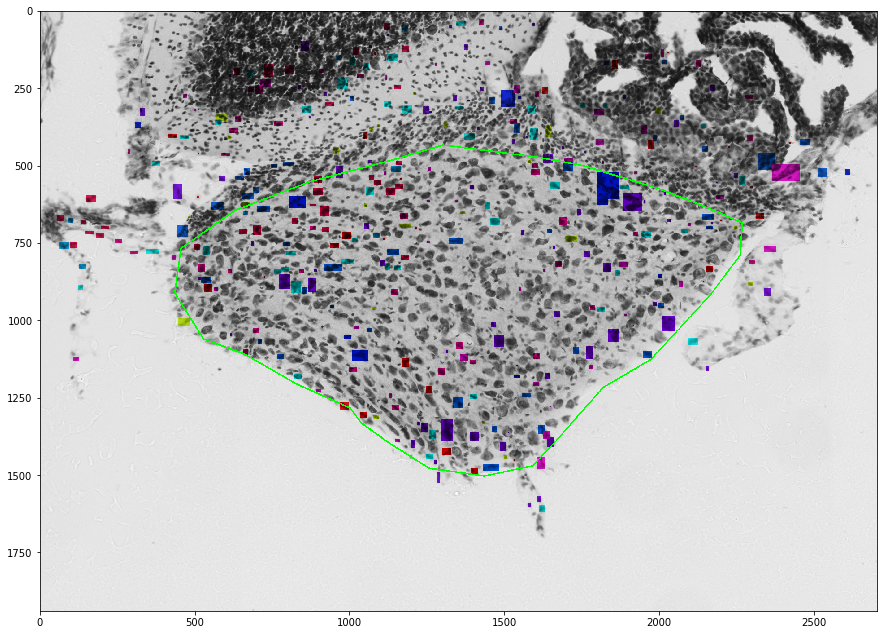

In [156]:
%%time
plt.figure(figsize=(15,15))
rgb = skimage.color.hsv2rgb(hsv)
rgb = rgb * 255
rgb = rgb.astype(np.uint8)
com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com)

In [49]:
origin= ['area', 'height', 'horiz_std', 'mean', 'padded_size',
       'rotation', 'rotation_confidence', 'std', 'vert_std', 'width', 'density']
columns = []
for i in range(10):
    name = 'DMVec'+str(i)
    for j in range(99):
        columns.append(name+'*'+str(j))
for i in range(10):
    name = origin[i]
    for j in range(99):
        columns.append(name+'*'+str(j))
columns.append(origin[-1])

In [50]:
len(columns)

1981

98 VCA 1 / 1
CPU times: user 21 s, sys: 1.17 s, total: 22.2 s
Wall time: 10.2 s


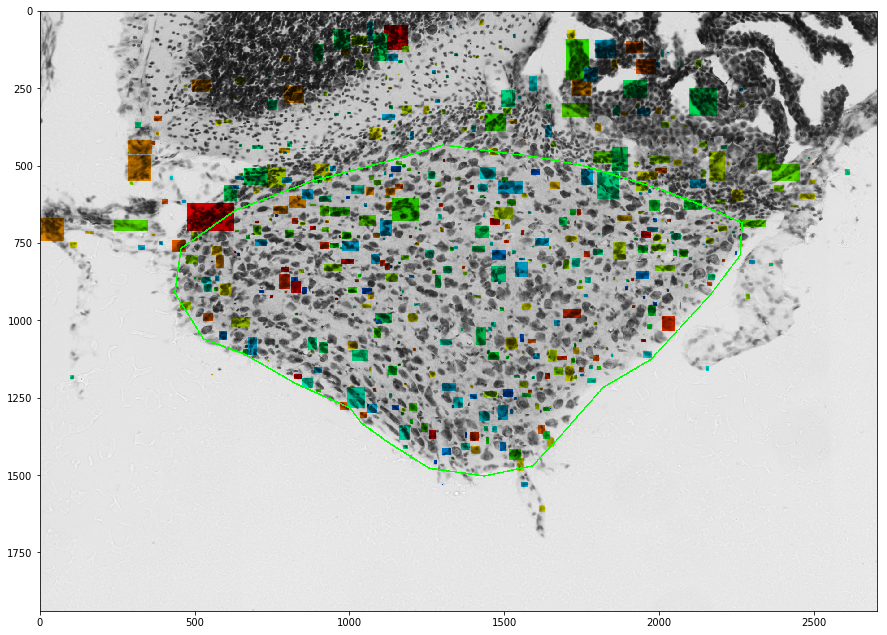

In [157]:
%%time
# hsv = np.zeros([m, n, 3])
# hsv[:, :, 2] = img / 255
count = 0
importances = {}
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()

    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))

    fp = []
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=columns)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'

    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin),n)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin),m))]
    hsv = np.zeros([down-up, right-left, 3])
    hsv[:, :, 2] = img[up:down,left:right] / 255
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    
#     inside_area = Polygon(polygon).area
#     outside_area = Polygon(polygon).buffer(margin, resolution=2).area - inside_area
    
    path = Path(polygon)
    indices_inside = np.where(path.contains_points(locations))[0]
    features_inside = features[indices_inside]
    locations_inside = locations[indices_inside]
    
    surround = Polygon(polygon).buffer(margin, resolution=2)
    path = Path(list(surround.exterior.coords))
    indices_sur = np.where(path.contains_points(locations))[0]
    indices_outside = np.setdiff1d(indices_sur, indices_inside)
    features_outside = features[indices_outside]
    locations_outside = locations[indices_outside]
    
    gains = bst.get_score(importance_type='total_gain')
    importances[structure] = {}
    for feature in gains.keys():
        if feature=='density':
            continue
        else:
            star = feature.rfind('*')
            name = feature[:star]
            if name not in importances[structure].keys():
                importances[structure][name] = {}
            importances[structure][name][feature] = gains[feature]
    features = importances[structure].keys()
    scores = {}
    for feature in features:
        total = np.array([importances[structure][feature][name] for name in importances[structure][feature].keys()]).sum()
        scores[feature] = total
    features_sorted = sorted(scores, key=scores.__getitem__, reverse=True)
    k = 0
    for feature in features_sorted:
        for name in importances[structure][feature].keys():
            index = np.where(columns==name)[0][0]
            raw = index // 99
            col = index % 99
            posi = np.argmin(np.absolute(features_inside[:,raw] - thresholds[raw][col]))
            cx = int(locations_inside[posi, 0])
            cy = int(locations_inside[posi, 1])
            height = int(features_inside[posi, 11]/2)
            width = int(features_inside[posi, 19]/2)
            hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 0] = 1.0/30*k
            hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 1] = 1.0

            nega = np.argmin(np.absolute(features_outside[:,k] - thresholds[raw][col]))
            cx = int(locations_outside[nega, 0])
            cy = int(locations_outside[nega, 1])
            height = int(features_outside[nega, 11]/2)
            width = int(features_outside[nega, 19]/2)
            hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 0] = 1.0/30*k
            hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 1] = 1.0
        k += 1
    polygon[:, 0] = polygon[:, 0] - left
    polygon[:, 1] = polygon[:, 1] - up
    plt.figure(figsize=(15,15))
    rgb = skimage.color.hsv2rgb(hsv)
    rgb = rgb * 255
    rgb = rgb.astype(np.uint8)
    com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
    plt.imshow(com)
    count += 1
    print(section, structure, count, '/', len(polygons))

In [158]:
features_sorted

['area',
 'rotation',
 'DMVec1',
 'height',
 'DMVec8',
 'DMVec9',
 'DMVec2',
 'DMVec4',
 'width',
 'std',
 'DMVec0',
 'DMVec7',
 'vert_std',
 'mean',
 'DMVec5',
 'horiz_std',
 'rotation_confidence',
 'DMVec3',
 'DMVec6']

In [160]:
importances[structure]['rotation']

{'rotation*41': 49.1905031,
 'rotation*13': 35.448301289999996,
 'rotation*17': 44.547069470000004,
 'rotation*64': 42.63132807,
 'rotation*25': 13.6777229,
 'rotation*37': 25.9326515,
 'rotation*42': 18.6413116,
 'rotation*14': 48.4673137,
 'rotation*55': 14.8438425,
 'rotation*22': 14.8636036,
 'rotation*53': 9.28033352,
 'rotation*15': 6.81440544,
 'rotation*21': 10.773571969999999,
 'rotation*38': 9.04612637,
 'rotation*95': 8.38524342,
 'rotation*30': 10.68695545,
 'rotation*65': 10.35155845,
 'rotation*33': 6.76099813,
 'rotation*5': 3.94582152,
 'rotation*85': 7.58957338,
 'rotation*11': 5.67674637,
 'rotation*39': 10.17602443,
 'rotation*46': 5.75394773,
 'rotation*88': 2.37589264,
 'rotation*18': 4.66977787,
 'rotation*9': 2.81003571,
 'rotation*31': 1.56502104,
 'rotation*66': 5.26693916,
 'rotation*43': 2.93929887,
 'rotation*86': 1.94718575}

In [125]:
columns = np.array(columns)

In [126]:
%%time
fp = []
fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
X_train = []
y_train = []
for state in range(2):
    clouds = pickle.load(open(fp[state], 'rb'))
    X_train.extend(np.array(clouds))
    y_train.extend([1 - state] * len(clouds))

fp = []
fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
for state in range(2):
    clouds = pickle.load(open(fp[state], 'rb'))
    X_train.extend(np.array(clouds))
    y_train.extend([1 - state] * len(clouds))
X_train = np.array(X_train)
y_train = np.array(y_train)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=columns)
bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

CPU times: user 18.7 s, sys: 478 ms, total: 19.1 s
Wall time: 7.72 s


In [64]:
columns[-1]

'density'

In [135]:
importances = {}
gains = bst.get_score(importance_type='total_gain')
importances[structure] = {}
for feature in gains.keys():
    if feature=='density':
        continue
    else:
        star = feature.rfind('*')
        name = feature[:star]
        if name not in importances[structure].keys():
            importances[structure][name] = {}
        importances[structure][name][feature] = gains[feature]
features = importances[structure].keys()
scores = {}
for feature in features:
    total = np.array([importances[structure][feature][name] for name in importances[structure][feature].keys()]).sum()
    scores[feature] = total
features_sorted = sorted(scores, key=scores.__getitem__, reverse=True)
for feature in features_sorted:
    for name in importances[structure][feature].keys():
        index = np.where(columns==name)[0][0]
        raw = index // 99
        col = index % 99
        

area*88 10 88
area*86 10 86
area*87 10 87
area*84 10 84
area*89 10 89
area*91 10 91
area*90 10 90
area*83 10 83
area*7 10 7
area*74 10 74
area*51 10 51
area*47 10 47
area*22 10 22
area*85 10 85
area*66 10 66
area*28 10 28
area*78 10 78
area*49 10 49
area*93 10 93
area*11 10 11
area*48 10 48
area*19 10 19
area*3 10 3
area*18 10 18
rotation*41 15 41
rotation*13 15 13
rotation*17 15 17
rotation*64 15 64
rotation*25 15 25
rotation*37 15 37
rotation*42 15 42
rotation*14 15 14
rotation*55 15 55
rotation*22 15 22
rotation*53 15 53
rotation*15 15 15
rotation*21 15 21
rotation*38 15 38
rotation*95 15 95
rotation*30 15 30
rotation*65 15 65
rotation*33 15 33
rotation*5 15 5
rotation*85 15 85
rotation*11 15 11
rotation*39 15 39
rotation*46 15 46
rotation*88 15 88
rotation*18 15 18
rotation*9 15 9
rotation*31 15 31
rotation*66 15 66
rotation*43 15 43
rotation*86 15 86
DMVec1*0 1 0
DMVec1*95 1 95
DMVec1*98 1 98
DMVec1*2 1 2
DMVec1*39 1 39
DMVec1*84 1 84
DMVec1*79 1 79
DMVec1*86 1 86
DMVec1*94 1 94
D

In [129]:
scores

{'area': 2093.99785642,
 'DMVec8': 369.23676853,
 'DMVec1': 412.98476642,
 'height': 374.302296969,
 'DMVec4': 249.882420637,
 'mean': 185.50069939999997,
 'DMVec2': 274.41250302490005,
 'rotation': 435.05910495,
 'std': 216.14634660500005,
 'DMVec9': 340.39929467,
 'horiz_std': 154.20615842,
 'width': 226.58974491,
 'DMVec5': 179.200472775,
 'DMVec0': 209.47829230899998,
 'DMVec3': 130.66170252700002,
 'vert_std': 194.81279561000002,
 'DMVec7': 205.03566453999997,
 'DMVec6': 120.232177252,
 'rotation_confidence': 153.549883587}

In [130]:
sorted(scores, key=scores.__getitem__, reverse=True)

['area',
 'rotation',
 'DMVec1',
 'height',
 'DMVec8',
 'DMVec9',
 'DMVec2',
 'DMVec4',
 'width',
 'std',
 'DMVec0',
 'DMVec7',
 'vert_std',
 'mean',
 'DMVec5',
 'horiz_std',
 'rotation_confidence',
 'DMVec3',
 'DMVec6']